# Les GNNs en pratique : accélération GPU via la bibliothèque PyTorch Geometric.

Ce tutoriel vise à explorer l'implémentation de différents GNNs via la librairie PyTorch Geometric. D'autres outils comme TensorboardX sont introduits afin de faciliter l'analyse de l'apprentissage des modèles.  

**Plan:**    

0. Pré-requis: Paramétrer son environnement Miniconda et Jupyter Lab, voir: (Insérer lien du document d'aide) 
1. Rappels sur PyTorch
2. Installation de PyTorch-Geometric
3. Définir un modèle GNN
4. Entrainer un modèle GNN
5. Un peu d'analyse

# 1. Rappels sur PyTorch

Bien que vous ayez déja manipulé PyTorch, nous allons rapidement revoir les bases de la mise en place de l'apprentissage d'un réseau de neurones. 

Premièrement, nous importons le nécessaire:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import sklearn.metrics as metrics

Comme souvent, nous allons utiliser le jeu de données MNIST afin de rapidement pouvoir expérimenter. Notons que Torchvision.datasets contient de très nombreux jeux de données. 

In [2]:
BATCH_SIZE = 32

## transformations
transform = transforms.Compose([transforms.ToTensor()])

## Téléchargement et chargement de MNIST (Train)
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

## Téléchargement et chargement de MNIST (Test)
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

In [3]:
print(len(trainset))
print(trainset[10])

60000
(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

Nous allons ici nous intéresser à la classification de chaque image parmis les 10 classes possibles (de 0 à 9). Pour ce faire, allons concevoir notre modèle neuronal profond en nous basant sur des couches convolutives et linéaires. N'hésitez pas à changer ce modèle. 

Pour rappel, l'héritage de `nn.Module` permet de bénéficier d'autograd. Ce mécanisme rends la rétro-propagation du gradient automatique. Nous devons donc implémenter certaines fonctions, comme `forward()`.


In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # 28x28x1 => 26x26x32
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.d1 = nn.Linear(26 * 26 * 32, 128)
        self.d2 = nn.Linear(128, 10)

    def forward(self, x):
        # 32x1x28x28 => 32x32x26x26
        x = self.conv1(x)
        x = F.relu(x)

        # flatten => 32 x (32*26*26)
        x = x.flatten(start_dim = 1)
        #x = x.view(32, -1)

        # 32 x (32*26*26) => 32x128
        x = self.d1(x)
        x = F.relu(x)

        # logits => 32x10
        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        return out

L'appel à la fonction `.to(str)` permet *d'envoyer* (entendre copier) un élément (un modèle, des donnèes, des fonctions) vers une source de calcul. 

In [5]:
import numpy as np
a = np.array([[1,2],[3,4]])
b = np.ones((2,2))

ta = torch.tensor(a, dtype=float).to('cuda:0')
tb = torch.ones(2,2, dtype=float).to('cuda:0')

print(ta)
print(ta @ tb)

tensor([[1., 2.],
        [3., 4.]], device='cuda:0', dtype=torch.float64)
tensor([[3., 3.],
        [7., 7.]], device='cuda:0', dtype=torch.float64)


Ensuite, il nous reste à:
1. Instancier le modèle
2. Définir une fonction de coût
3. Définir l'optimiseur

In [6]:
learning_rate = 0.001
num_epochs = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Vient ensuite la boucle d'apprentissage pendant laquelle nous allons itérer sur tout le jeu de donnée. Pour chaque mini-batch, nous allons invoquer la descente de gradient et la mise à jour des poids. 

In [7]:
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    ## Apprentissage
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## propagation avant + rétropropagation + fonction de coût
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## mise à jour !
        optimizer.step()

        ## On récupère la fonction de coup et la précision pour analyse
        train_running_loss += loss.detach().item()
        train_acc += (torch.argmax(logits, 1).flatten() == labels).type(torch.float).mean().item()
    
    print('Itération: %d | Loss: %.4f | Précision Train: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))

Itération: 0 | Loss: 1.6406 | Précision Train: 0.82
Itération: 1 | Loss: 1.4969 | Précision Train: 0.97
Itération: 2 | Loss: 1.4841 | Précision Train: 0.98
Itération: 3 | Loss: 1.4783 | Précision Train: 0.99
Itération: 4 | Loss: 1.4751 | Précision Train: 0.99


Enfin, nous devons juste ré-utiliser le modèle entrainé afin de l'évaluer sur le corpus de test.

In [8]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += (torch.argmax(outputs, 1).flatten() == labels).type(torch.float).mean().item()
    preds = torch.argmax(outputs, 1).flatten().cpu().numpy()
        
print('Précision Test: %.2f'%(test_acc/i))

Précision Test: 0.98


# 2. Installation de PyTorch-Geometric

Ici, nous allons juste installer PyTorch-Geometric et TensorboardX dans notre environnement anaconda. 

In [9]:
!pip install torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
!pip install torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
!pip install torch-cluster==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
!pip install torch-spline-conv==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.6.0.html
     |████████████████████████████████| 11.5 MB 15.3 MB/s eta 0:00:01
Looking in links: https://pytorch-geometric.com/whl/torch-1.6.0.html
     |████████████████████████████████| 22.9 MB 76.9 MB/s eta 0:00:01
  Attempting uninstall: torch-sparse
    Found existing installation: torch-sparse 0.6.7
    Uninstalling torch-sparse-0.6.7:
      Successfully uninstalled torch-sparse-0.6.7
Looking in links: https://pytorch-geometric.com/whl/torch-1.6.0.html
     |████████████████████████████████| 20.2 MB 16.2 MB/s eta 0:00:01
Looking in links: https://pytorch-geometric.com/whl/torch-1.6.0.html
     |████████████████████████████████| 6.1 MB 13.1 MB/s eta 0:00:01
  Using cached tensorboardX-2.1-py2.py3-none-any.whl (308 kB)


     |████████████████████████████████| 1.3 MB 6.9 MB/s eta 0:00:01


In [29]:
!pip install tensorboard

     |████████████████████████████████| 6.8 MB 5.8 MB/s eta 0:00:01
     |████████████████████████████████| 779 kB 24.8 MB/s eta 0:00:01
     |████████████████████████████████| 91 kB 6.9 MB/s  eta 0:00:01
     |████████████████████████████████| 3.4 MB 18.7 MB/s eta 0:00:01
  Using cached Werkzeug-1.0.1-py2.py3-none-any.whl (298 kB)
     |████████████████████████████████| 127 kB 15.5 MB/s eta 0:00:01
  Using cached google_auth_oauthlib-0.4.1-py2.py3-none-any.whl (18 kB)
  Using cached Markdown-3.2.2-py3-none-any.whl (88 kB)
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
  Using cached rsa-4.6-py3-none-any.whl (47 kB)
  Using cached requests_oauthlib-1.3.0-py2.py3-none-any.whl (23 kB)
  Using cached pyasn1-0.4.8-py2.py3-none-any.whl (77 kB)
  Using cached oauthlib-3.1.0-py2.py3-none-any.whl (147 kB)


Et nous testons en important tout ce qui est nécessaire:

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

import time
from datetime import datetime

import networkx as nx
import numpy as np
import torch
import torch.optim as optim

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.transforms as T

from torch.utils.tensorboard import SummaryWriter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# 3. Définir un modèle GNN

Appelons `GNN` notre modèle héritant de `nn.Module`. Nous allons également essayer de proposer plusieurs types de couches de GNNs. Pour ce faire, nous créons une fonction `build_conv_model` permettant de facilement changer ce paramètre tout en construisant le modèle. Ici, nous propose un GCNN pour une tâche de classification de noeuds et un GIN pour une tâche de classification de graphes. PyTorch-Geometric permet justement d'instancier très facilement ces couches (tout comme nn.Conv, nn.Linear, etc ..).

In [22]:
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, task='node'):
        super(GNN, self).__init__()
        self.task = task
        self.convs = nn.ModuleList()
        self.convs.append(self.build_conv_model(input_dim, hidden_dim))
        
        # Notre profondeur est de 2 (i.e 2 sauts dans le voisinage)
        for l in range(2):
            self.convs.append(self.build_conv_model(hidden_dim, hidden_dim))

        # Une fois ces sauts effectués et le message passé,
        # nous appliquons quelques non-linéaritées. 
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(0.25), 
            nn.Linear(hidden_dim, output_dim))
        if not (self.task == 'node' or self.task == 'graph'):
            raise RuntimeError('Tâche inconnue :-(')

        self.dropout = 0.25
        self.num_layers = 3

    def build_conv_model(self, input_dim, hidden_dim):
        
        # La documentation de PyTorch-Geometric vous proposera différents types de couches existantes.
        if self.task == 'node':
            return pyg_nn.GCNConv(input_dim, hidden_dim)
        else:
            return pyg_nn.GINConv(nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                  nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)))

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        if data.num_node_features == 0:
            x = torch.ones(data.num_nodes, 1)

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            emb = x
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        if self.task == 'graph':
            x = pyg_nn.global_mean_pool(x, batch)

        x = self.post_mp(x)

        return emb, F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        # Nous définissons ici directement la fonction de coût.
        return F.nll_loss(pred, label)

D'accord, mais si je souhaite développer ma propre couche de GNN ? C'est tout de même là tout l'intéret de la recherche !

Et bien ici, `pyg_nn.GCNConv` et `pyg_nn.GINConv` sont des instances de `MessagePassing`. Ils définissent une seule et unique couche de convolution de graphes qui est décomposable par:

* Calcul du message
* Aggregation
* Mise à jour
* Pooling

Ainsi, il est tout à fait possible de définir sa propre couche en héritant de `MessagePassing` (comme nous l'aurions fait avec `nn.Module`).

Nous utiliserons donc des éléments pré-existants de `MessagePassing` pour nous faciliter la tâche:
- `aggr='add'`: La méthode d'aggrégation ("add", "mean" ou "max").
- `propagate()`: L'appel initial permettant de démarrer la propagation du message. Nécessite les indices des arcs.
- `message()`: Construit le message au noeud i. Récupère les arguments de `propagate()`.
- `update()`: Mise à jour des embeddings des noeuds. Le premier argument correspond à la sortie de l'aggregation et tous les arguments de `propagate()`. 


In [23]:
class CustomConv(pyg_nn.MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(CustomConv, self).__init__(aggr='add')  # "Add" aggregation.
        self.lin = nn.Linear(in_channels, out_channels)
        self.lin_self = nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x: [N, in_channels]
        # edge_index: [2, E]

        # Ajouter une boucle à la matrice d'adjacence.
        edge_index, _ = pyg_utils.remove_self_loops(edge_index)

        # On transforme les données du noeud. 
        self_x = self.lin_self(x)
        #x = self.lin(x)

        return self_x + self.propagate(edge_index, size=(x.size(0), x.size(0)), x=self.lin(x))

    def message(self, x_i, x_j, edge_index, size):
        # Nous calculons les messages.
        # x_j: [E, out_channels]

        row, col = edge_index
        deg = pyg_utils.degree(row, size[0], dtype=x_j.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        return x_j

    def update(self, aggr_out):
        # aggr_out: [N, out_channels]
        return aggr_out

# 4. Entrainer un modèle GNN

**IMDB-BINARY**: Référence: *https://dl.acm.org/doi/pdf/10.1145/2783258.2783417*. IMDB-BINARY sera utilisé comme corpus pour une tâche de classification de graphes. Ici, des acteurs/actrices ainsi que le genre de plusieurs films ont été collectés sur le site IMDB. Pour chaque graphe, les noeuds représentent un acteur ou une actrice, et les arcs représentent leur apparition dans un même film. Pour chaque acteur / actrice, un ego-network est généré (comprendre, un graphe centré autour d'une seule personne). La tâche est ici de classifier chaque ego-network vers le genre correspondant (i.e. romance ou action dans le cas de IMBN-BINARY).

**CORA**: Cora propose un graphe reliant les publications scientifiques entre elles. Chaque noeud est un document (sac-de-mots) et les arcs représentent les différentes citation. Chaque document appartient à un thème. La tâche est de prédire ce thème.

La boucle d'apprentissage de notre GNN est très similaire à celle de MNIST. La seule différence concerne le fait de proposer deux tâches (classification de noeuds ou de graphes). 

**Pour la classification de noeuds:** nous devons définir un sous-ensemble de noeuds sur lesquels entrainer notre modèle. Dans les faits, nous disposons d'un ensemble de graphes dont chaque noeud est correment annoté. De ce fait, nous devons en masquer certains afin de permettre l'évaluation de notre modèle (**nous n'avons pas le droit d'apprendre sur le test !!!**).    

**Pour la classification de graphes:** il nous suffit de partitioner le corpus. Nous utiliserons 80% des graphes pour l'apprentissage et 20% pour l'évaluation.

In [44]:
def train(dataset, task, writer):
    if task == 'graph':
        data_size = len(dataset)
        loader = DataLoader(dataset[:int(data_size * 0.8)], batch_size=64, shuffle=True)
        test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size=64, shuffle=True)
    else:
        test_loader = loader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Construction du modèle.
    model = GNN(max(dataset.num_node_features, 1), 32, dataset.num_classes, task=task)
    opt = optim.Adam(model.parameters(), lr=0.001)
    
    # Apprentissage
    for epoch in range(200):
        total_loss = 0
        model.train()
        for batch in loader:
            
            opt.zero_grad()
            embedding, pred = model(batch)
            label = batch.y
            if task == 'node':
                # En cas de classification de noeuds, nous en masquons certains.
                pred = pred[batch.train_mask]
                label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        writer.add_scalar("loss", total_loss, epoch)

        if epoch % 10 == 0:
            test_acc = test(test_loader, model)
            print("Itération {}. Loss: {:.4f}. Précision test: {:.4f}".format(
                epoch, total_loss, test_acc))
            writer.add_scalar("Précision test", test_acc, epoch)

    return model


Dans le cas de CiteSeer/Cora. La tâche de classification des noeuds porte sur un seul et unique graphe. Il est donc primordial de masquer convenablement ces derniers afin de faire une distinction entre validation et test. 

In [45]:
def test(loader, model, is_validation=False):
    model.eval()

    correct = 0
    for data in loader:
        with torch.no_grad():
            emb, pred = model(data)
            pred = pred.argmax(dim=1)
            label = data.y

        if model.task == 'node':
            mask = data.val_mask if is_validation else data.test_mask
            # En cas de classification de noeuds, nous ne considérons que ceux masqués !
            pred = pred[mask]
            label = data.y[mask]
            
        correct += pred.eq(label).sum().item()
    
    if model.task == 'graph':
        total = len(loader.dataset) 
    else:
        total = 0
        for data in loader.dataset:
            total += torch.sum(data.test_mask).item()
    return correct / total

## Classification de graphes

Nous allons à présent entrainer notre modèle sur la tâche de classification de graphes et visualiser l'apprentissage via Tensorboard. D'abord, nous devons lancer le serveur tensorboard.

In [9]:
get_ipython().system_raw(
    'tensorboard --logdir {} --port 6006 &'
    .format("./log")
)

Notre apprentissage concerne le corpus IMDB-BINARY et la classification d'ego-networks en deux genres de film: Action ou Romance. Nous démarrons donc l'apprentissage. Après les premières itérations, les courbes de loss et précision devrait être visible dans tensorboard.

In [33]:
writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

dataset = TUDataset(root='/tmp/IMDB-BINARY', name='IMDB-BINARY')
dataset = dataset.shuffle()
task = 'graph'

model = train(dataset, task, writer)

Itération 0. Loss: 0.8597. Précision test: 0.4400
Itération 10. Loss: 0.6345. Précision test: 0.6000
Itération 20. Loss: 0.6130. Précision test: 0.6650
Itération 30. Loss: 0.5798. Précision test: 0.7050
Itération 40. Loss: 0.5834. Précision test: 0.6900
Itération 50. Loss: 0.5721. Précision test: 0.6650
Itération 60. Loss: 0.5761. Précision test: 0.6650
Itération 70. Loss: 0.5659. Précision test: 0.7150
Itération 80. Loss: 0.5627. Précision test: 0.7050
Itération 90. Loss: 0.5440. Précision test: 0.7000
Itération 100. Loss: 0.5573. Précision test: 0.7150
Itération 110. Loss: 0.5602. Précision test: 0.7000
Itération 120. Loss: 0.5540. Précision test: 0.6850
Itération 130. Loss: 0.5443. Précision test: 0.7050
Itération 140. Loss: 0.5418. Précision test: 0.7000
Itération 150. Loss: 0.5566. Précision test: 0.7200
Itération 160. Loss: 0.5447. Précision test: 0.7150
Itération 170. Loss: 0.5436. Précision test: 0.7150
Itération 180. Loss: 0.5474. Précision test: 0.7100
Itération 190. Loss: 0.

## Classification de noeuds


À présent nous changeons l'application pour une classification de noeuds via le corpus CORA. Pour rappel, chaque noeud est une publication associée à un thème spécifique et les arcs représentent les citations. La tâche est de prédire le thème associé à un document.

In [46]:
writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

dataset = Planetoid(root='/tmp/cora', name='cora')
task = 'node'

model = train(dataset, task, writer)

Itération 0. Loss: 1.9592. Précision test: 0.0640
Itération 10. Loss: 1.9320. Précision test: 0.1610
Itération 20. Loss: 1.8556. Précision test: 0.2690
Itération 30. Loss: 1.6984. Précision test: 0.3140
Itération 40. Loss: 1.4151. Précision test: 0.4080
Itération 50. Loss: 1.1248. Précision test: 0.6430
Itération 60. Loss: 0.8839. Précision test: 0.6800
Itération 70. Loss: 0.7144. Précision test: 0.7320
Itération 80. Loss: 0.5055. Précision test: 0.7290
Itération 90. Loss: 0.3617. Précision test: 0.7310
Itération 100. Loss: 0.2658. Précision test: 0.7620
Itération 110. Loss: 0.2104. Précision test: 0.7490
Itération 120. Loss: 0.1476. Précision test: 0.7510
Itération 130. Loss: 0.0937. Précision test: 0.7640
Itération 140. Loss: 0.0908. Précision test: 0.7680
Itération 150. Loss: 0.0818. Précision test: 0.7530
Itération 160. Loss: 0.0868. Précision test: 0.7550
Itération 170. Loss: 0.0640. Précision test: 0.7590
Itération 180. Loss: 0.0666. Précision test: 0.7580
Itération 190. Loss: 0.

# 5. Un peu d'analyse

Tout comme de nombreuses architectures neuronales profondes, les différentes couches des GNNs offrent d'intéressantes réductions de dimensions de l'information initiale. Par exemple, dans le cas de la classification de noeuds, nous obtenons pour chaque noeud une représentation de dimension inférieure. Nous pouvons donc utiliser différentes méthode de visualisation (comme T-SNE) pour en apprendre d'avantage sur ces représentations intermédiaires. Ici, nous nous intéressons à la dernière couche convolutive du GNN.    

Un point = un noeud     
Un thème = un thème (classe / label)

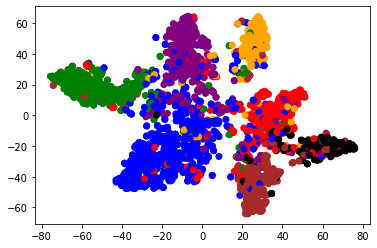

In [50]:
color_list = ["red", "orange", "green", "blue", "purple", "brown", "black"]

loader_here = DataLoader(dataset, batch_size=64, shuffle=True)
embs = []
colors = []
for batch in loader_here:
    emb, pred = model(batch)
    embs.append(emb)
    colors += [color_list[y] for y in batch.y]
embs = torch.cat(embs, dim=0)

xs, ys = zip(*TSNE().fit_transform(embs.detach().numpy()))
plt.scatter(xs, ys, color=colors)

Nous pouvons voir que les noeuds ayant un label similaire se retrouvent assez proche dans notre espace latent. C'est une bonne indication de la qualité de notre représentation DANS LE CAS d'une classification par thème. Ce n'est qu'une indication, car la T-SNE, comme tout méthode de réduction, compresse l'information.